# KVLCC2 Ikeda estimators

# Purpose
The are a lot of different ways to implement Ikeda's method. This notebook is creating a lot of different estimators and saving this to pkl files.

# Methodology
Build the estimators and save them

# Setup

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
import shipflowmotionshelpers.shipflowmotionshelpers as helpers
import shipflowmotionshelpers.preprocess as preprocess


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [30]:
import joblib
from src.helpers import get_ikeda, calculate_ikeda, get_estimator_variation, get_data_variation , get_variation, hatify
from rolldecayestimators import fit_on_amplitudes
from copy import deepcopy
import rolldecayestimators.ikeda as ikeda_classes
import rolldecayestimators.ikeda_speed
import scipy
import rolldecayestimators.ikeda_speed
import src.helpers
from pyscores2.runScores2 import Calculation
from pyscores2.indata import Indata
from pyscores2.output import OutputFile
import src.visualization.visualize as visualize
from reports import mdl_results
from notebook_helpers import load_time_series_fnpf

import reports.examples.FNPF

## Load data from FNPF:

In [4]:
df_parameters = pd.read_csv('../../data/processed/roll decay KVLCC2/fnpf_parameters.csv', index_col=0)
df_parameters.head()

,B,IXY,IXZ,IYY,IYZ,IZZ,KXX,KXY,KYY,KZZ,LPP,S,V,XCG,YCG,ZCG,accx,acto,b1c,b1cr,b1l,b1q,b2c,b2cr,b2l,b2q,b3c,b3cr,b3l,b3q,b4c,b4cr,b4l,b4q,b5c,b5cr,b5l,b5q,b6c,b6cr,b6l,b6q,bdens,body,clev,clevel,curv,dens,densi,dofa,dofactor,dopa,dopadding,dopo,dopower,down,downs,downst,dt,file,file_path_ts,fn,form,free,gravi,heave,heel,hull,inter,k1nd,k2nd,k3nd,k4nd,k5nd,k6nd,kxx,kyy,leve,level,lpp,m,maxti,maxtime,mesh,name,npxp,npyp,nstep,nthr,pitch,powe,power,refle,reflen,rn,roll,rud1,rud2,rud3,rud4,rud5,rud6,rudt,side,slim,stre,strength,surge,sway,ta,tf,tfnhi,tfnhigh,tfnlo,tfnlow,titl,title,trim,upst,upstr,vm_s,wlin,wlme,yaw,ymax,ymin,zcg,conv,encounters,id
kvlcc2_rolldecay_0kn,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.050,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.00000,0.00000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,50.0,50.0,2.0,2.0,2.0,2.0,1.00,-5.0,1.00,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,1.472020e-07,0.23,0.3,9.80665,0.0,0.0,0.002,0.000000e+00,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,180.0,180.0,0.000000e+00,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3.957280e+00,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,30.0,0.50,0.50,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,1.00,5.0,0.000001,0.000001,0.000001,0.0,5.0,-5.0,0.2735,NaN,NaN,21338.0
kvlcc2_rolldecay_15-5kn_const_large2,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.025,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.00000,0.00000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,1.0,1.0,2.0,2.0,1.0,1.0,0.70,-5.0,0.70,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,1.423410e-01,0.23,0.3,9.80665,0.0,0.0,0.002,0.000000e+00,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,200.0,200.0,0.000000e+00,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3.826600e+06,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.70,30.0,0.05,0.05,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,0.70,5.0,0.966976,0.000001,0.000001,0.0,5.0,-5.0,0.2735,NaN,NaN,21340.0
kvlcc2_rolldecay_15-5kn_ikeda_dev,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.050,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6.07217,2.74371,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00004,1000.0,1000.0,0.0,0.0,2.0,2.0,1.0,1.0,0.25,-2.0,0.25,NaN,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,1.423410e-01,0.20,0.3,9.80665,0.0,0.0,0.002,1.000000e-07,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,600.0,600.0,1.000000e-07,TRAN,24.0,24.0,30.0,6.0,0.0,2.0,2.0,4.706,4.706,3.826600e+06,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,30.0,1.00,1.00,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,0.25,2.0,0.966976,0.000001,0.000001,0.0,2.0,-2.0,0.2735,0.0001,0.0,21340.0


## Load MDL results

In [11]:
df_rolldecays = mdl_results.df_rolldecays

## Bilge radius

In [12]:
scale_factor = df_rolldecays.iloc[0].scale_factor
lpp = df_rolldecays.iloc[0].lpp/scale_factor

Rs_data = [
          [lpp*scale_factor,40],    
          [290,15.21],
          [225,2.4],
          [129,2.4],
          [45,8.48],
          [0,40],  
            ]  # Measured on full scale geometry


df_Rs = pd.DataFrame(data=Rs_data, columns=['x','R_b'])
df_Rs['R_b']/=scale_factor
df_Rs['x']/=scale_factor
df_Rs['station'] = df_Rs['x']/lpp*20
df_Rs.sort_values(by='station', inplace=True)

stations = np.arange(0,21,1)
df_Rs_interp = pd.DataFrame(index=stations)

df_Rs_interp['R_b'] = np.interp(stations,df_Rs['station'].values,df_Rs['R_b'].values)

In [14]:
df_areas = pd.read_csv('../../data/interim/kvlcc_areas.csv', sep=';', index_col=0)
df_areas.head()

,area,x,t,b,r_b
no,,,,,
0,13.826612,-5.495000,2.00,11.638577,6.636080
1,123.851306,10.159932,18.25,27.893522,42.367175
2,428.211409,28.051284,20.80,41.824284,45.369454
3,683.709165,43.706216,20.80,50.282514,41.080696
4,917.895066,61.597568,20.80,56.159232,34.146143


In [15]:
df_areas_model = df_areas.copy()
df_areas_model['area']/=(scale_factor**2)
df_areas_model['x']/=(scale_factor)
df_areas_model['t']/=(scale_factor)
df_areas_model['b']/=(scale_factor)
df_areas_model['r_b']/=(scale_factor)



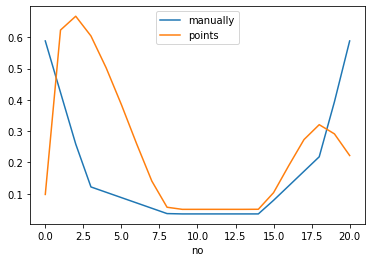

In [16]:
fig,ax=plt.subplots()
df_Rs_interp.plot(y='R_b', label='manually',ax=ax)
df_areas_model.plot(y='r_b', label='points',ax=ax)
ax.legend()

In [18]:
c_r_tree = joblib.load('../../models/C_r_tree.pkl')

def predict_C_r(sigma, a_3):
    
    X = np.array([sigma,a_3]).T
    
    return c_r_tree.predict(X)
    

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\reports\venv\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [21]:
run_paths={
    21338 : {
        'scores_indata_path':'../../models/KVLCC2_speed.IN',
        'scores_outdata_path':'../../data/interim/KVLCC2_speed.out',
        'roll_decay_model':'../../models/KVLCC2_0_speed.pkl',
        'motions_file_paths': ['kvlcc2_rolldecay_0kn'],
        'combined_motions_ikeda': ['kvlcc2_rolldecay_0kn'],  ## hybrid model with motions and Ikeda
            
            },
    21340 : {
        'scores_indata_path':'../../models/KVLCC2_speed.IN',
        'scores_outdata_path':'../../data/interim/KVLCC2_speed.out',
        'roll_decay_model':'../../models/KVLCC2_speed.pkl',
        #'motions_file_paths': ['kvlcc2_rolldecay_15-5kn'],
        #'combined_motions_ikeda': ['kvlcc2_rolldecay_15-5kn'],  ## hybrid model with motions and Ikeda
        'motions_file_paths': ['kvlcc2_rolldecay_15-5kn_const_large2'],
        'combined_motions_ikeda': ['kvlcc2_rolldecay_15-5kn_const_large2'],  ## hybrid model with motions and Ikeda
        
    }
}

## Build Ikeda estimators:

In [22]:
runs = OrderedDict()

for run_id, run in run_paths.items():
    
    mdl_meta_data = df_rolldecays.loc[run_id]
    runs[run_id] = new_run = {
        'ikedas':OrderedDict(),
    }
    ikedas = new_run['ikedas']
    
    ## Common data:
    scale_factor = mdl_meta_data.scale_factor
    indata_file_path=run['scores_indata_path']
    output_file_path=run['scores_outdata_path']
    motions_file_path=run['motions_file_paths'][0]  # Assuming same parameters
    parameters = df_parameters.loc[motions_file_path]
    
    ## Load ScoresII results
    indata = Indata()
    indata.open(indataPath=indata_file_path)
    output_file = OutputFile(filePath=output_file_path)
   
    V = mdl_meta_data.ship_speed*1.852/3.6/np.sqrt(scale_factor)
    
    if not mdl_meta_data.BKL:
        BKL=0
    else:
        BKL=mdl_meta_data.BKL/scale_factor
    
    if not mdl_meta_data.BKB:
        BKB = 0
    else:
        BKB=mdl_meta_data.BKB/scale_factor
    
    
    kg=mdl_meta_data.kg/scale_factor
    
    
    ## Various Ikeda models:
    
    # Regular ikeda (ikeda bilge radius approx.)
    name = 'ikeda'
    ikedas[name] = {}
    ikedas[name]['estimator'] = ikeda_classes.Ikeda.load_scoresII(V=V, w=None, fi_a=None, indata=indata, output_file=output_file, 
                                scale_factor=scale_factor, BKL=BKL, BKB=BKB, kg=kg)
    
    # ikeda (bilge radius from CAD)
    name = 'ikeda_r'
    ikedas[name] = {}
    R_b = df_Rs_interp['R_b'].values
    ikedas[name]['estimator'] = ikeda_classes.IkedaR.load_scoresII(V=V, w=None, fi_a=None, indata=indata, output_file=output_file, 
                                scale_factor=scale_factor, BKL=BKL, BKB=BKB, kg=kg, R_b=R_b)
    
    # ikeda (bilge radius from CAD)
    name = 'ikeda_s'
    ikedas[name] = {}
    #R_b = df_Rs_interp['R_b'].values
    R_b = df_areas_model['r_b'].values
        
    ikedas[name]['estimator'] = ikeda_classes.IkedaR.load_scoresII(V=V, w=None, fi_a=None, indata=indata, output_file=output_file, 
                                scale_factor=scale_factor, BKL=BKL, BKB=BKB, kg=kg, R_b=R_b)
    
    # Same as Ikeda class but with mandatory wetted surface.
    name = 'ikeda_s'
    ikedas[name] = {}
    S_f = parameters.S
    
    ikedas[name]['estimator'] = ikeda_classes.IkedaS.load_scoresII(V=V, w=None, fi_a=None, indata=indata, output_file=output_file, 
                                scale_factor=scale_factor, BKL=BKL, BKB=BKB, kg=kg, S_f=S_f)
    
    # Same as Ikeda class but with mandatory wetted surface and bilge radius from CAD.
    name = 'ikeda_r_s'
    ikedas[name] = {}
    S_f = parameters.S
    
    ikedas[name]['estimator'] = ikeda_classes.IkedaR.load_scoresII(V=V, w=None, fi_a=None, indata=indata, output_file=output_file, 
                                scale_factor=scale_factor, BKL=BKL, BKB=BKB, kg=kg, S_f=S_f, R_b=R_b, sigma_limit=1.0)
    
    # Same as Ikeda eddy damping for barge.
    #name = 'ikeda_barge'
    #ikedas[name] = {}
    #    
    #ikedas[name]['estimator'] = ikeda_classes.IkedaBarge.load_scoresII(V=V, w=None, fi_a=None, indata=indata, output_file=output_file, 
    #                            scale_factor=scale_factor, BKL=BKL, BKB=BKB, kg=kg)
    
    
    # Same as Ikeda manual C_r.
    name = 'ikeda_C_r'
    ikedas[name] = {}
    
    ikedas[name]['estimator'] = estimator = ikeda_classes.IkedaCr.load_scoresII(V=V, w=None, fi_a=None, indata=indata, output_file=output_file, 
                                scale_factor=scale_factor, BKL=BKL, BKB=BKB, kg=kg, S_f=S_f, R_b=R_b)
    a, a_1, a_3, sigma_s, H = estimator.calculate_sectional_lewis_coefficients()
    estimator.C_r = predict_C_r(sigma=sigma_s, a_3=a_3)
    


C:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
C:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


## Saving Ikeda estimators:

In [23]:
for id,run in runs.items():
    for ikeda_name, ikeda in run['ikedas'].items():
        
        file_name = '%s_%s.pkl' % (id,ikeda_name)
        joblib.dump(ikeda['estimator'], '../../models/%s' % file_name)
        

## Load time series from FNPF

In [28]:
time_series = load_time_series_fnpf(names=df_parameters.index)

## Load FNPF models

In [33]:
motion_models, df_results_motions = reports.examples.FNPF.get_models_and_results()

In [34]:
for run_id, run in run_paths.items():
    
    mdl_meta_data = df_rolldecays.loc[run_id]
        
    new_run = runs[run_id]
    
    ## MDL:
    model_mdl = joblib.load(run['roll_decay_model'])
    estimator_mdl = model_mdl['estimator']
    estimator_mdl.calculate_amplitudes_and_damping()
    new_run['model_mdl']=model_mdl
    new_run['estimator_mdl']=estimator_mdl
    
    scale_factor = mdl_meta_data.scale_factor
    new_run['meta_data'] = meta_data={
            'Volume':mdl_meta_data.Volume/(scale_factor**3),
            'GM':mdl_meta_data.gm/scale_factor,
            'rho':mdl_meta_data.rho,
            'g':mdl_meta_data.g,
            'beam':mdl_meta_data.beam/scale_factor,
        }
    
    new_run['results'] = estimator_mdl.result_for_database(meta_data=meta_data)
    results = new_run['results']
    
    # Prediction
    new_run['df_model'] = get_estimator_variation(estimator = estimator_mdl, results=results, meta_data=meta_data)
    
    # Model tests
    new_run['df'] = get_data_variation(estimator = estimator_mdl, results=results, meta_data=meta_data)
    phi_a = new_run['df']['phi_a']
    
    ## Motions
    new_run['motions'] = OrderedDict()
    for motions_file_path in run.get('motions_file_paths',[]):
        motion_file = new_run['motions'][motions_file_path] = {}
        
        motion_file['parameters'] = parameters = df_parameters.loc[motions_file_path]
        
        motion_file['X'] = X = time_series[motions_file_path]
        
                
        motion_file['model'] = model = motion_models[motions_file_path]
        #assert model.score() > 0.90
        
        motion_file['meta_data'] = meta_data ={
            'Volume':parameters.V,
            'GM':mdl_meta_data.gm/mdl_meta_data.scale_factor,
            'rho':parameters.dens,
            'g':parameters.gravi,
            'beam':parameters.B,
        }
    
        results = model.result_for_database(meta_data=meta_data)
        if not 'B_3' in results:
            results['B_3'] = 0
        
        motion_file['results'] = results
        model.calculate_amplitudes_and_damping()
        
        # Prediction
        motion_file['df_model'] = get_estimator_variation(estimator = model, results = results, meta_data=meta_data)
                
        # Simulation
        motion_file['df'] = get_data_variation(estimator = model, results = results, meta_data=meta_data)
        
                
    ## Ikeda
    for ikeda_name, ikeda in new_run['ikedas'].items():
                   
        omega0=new_run['results']['omega0']
        #phi_a=new_run['results']['phi_a']
        ikeda_estimator = ikeda['estimator']
        ikeda['df'] = results = ikeda_estimator.calculate(w=omega0, fi_a=phi_a)
        
        results['phi_a'] = phi_a
        results.set_index('phi_a', inplace=True)
        
        ## Convert to dimensional damping [Nm/s]
        ikeda['meta_data'] = meta_data = new_run['meta_data']
        result_ = src.helpers.unhat(df=results, Disp=meta_data['Volume'], beam=meta_data['beam'], g=meta_data['g'], rho=meta_data['rho'])
        ikeda['df'] = results = pd.concat((results,result_), axis=1)
       
        ## Feed the results into a quadratic model:
        output = fit_on_amplitudes.fit_quadratic(y=results['B_44'], phi_a=results.index, omega0=omega0, 
                                    B_1_0=new_run['results']['B_1'], 
                                    B_2_0=new_run['results']['B_2'], 
                                    )
        
        parameters = {
            'B_1A': output['B_1'] / new_run['results']['A_44'],
            'B_2A': output['B_2'] / new_run['results']['A_44'],
            'B_3A': 0,
            'C_1A': estimator_mdl.parameters['C_1A'],
            'C_3A': estimator_mdl.parameters['C_3A'],
            'C_5A': estimator_mdl.parameters['C_5A'],
        }
        ikeda['model'] = EstimatorCubic.load(**parameters, X=estimator_mdl.X)
        
        
        ikeda['results'] = ikeda['model'].result_for_database(meta_data=meta_data)
        ikeda['df_model'] = get_estimator_variation(estimator = ikeda['model'], results = ikeda['results'], meta_data=new_run['meta_data'])
    
    ## Combined model:
    new_run['combined_models'] = combined_models =  {}
    combined_motions_ikedas = run.get('combined_motions_ikeda',[])
    for combined_motions_ikeda in combined_motions_ikedas:
        
        combined_models[combined_motions_ikeda] = combined_model = {}
        
        combined_model['motions'] = model_motions = new_run['motions'][combined_motions_ikeda]
        combined_model['ikedas'] = OrderedDict()
                
        for ikeda_name, ikeda in new_run['ikedas'].items():
            
            combined_model['ikedas'][ikeda_name] = combined_model_ikeda = {}
                        
            df = ikeda['df']
            df_motions = pd.DataFrame()
            df_motions['phi_a'] = df.index.copy()
            df_motions = get_variation(X_amplitudes=df_motions, results = model_motions['results'], meta_data=model_motions['meta_data'])
            df_motions.set_index('phi_a', inplace=True)
                    
            columns_visc = ['B_L','B_F','B_E','B_BK']
            df_combined = df[columns_visc].copy()
            df_combined['B_W'] = df_motions['B_e']
            df_combined['B'] = df_combined.sum(axis=1)
            combined_model_ikeda['df'] = df_combined
            
             ## Feed the results into a cubic model:
            output = fit_on_amplitudes.fit_quadratic(y=df_combined['B'], phi_a=df_combined.index, omega0=omega0, 
                                    B_1_0=new_run['results']['B_1'], 
                                    B_2_0=new_run['results']['B_2'], 
                                    )
        
            parameters = {
                'B_1A': output['B_1'] / new_run['results']['A_44'],
                'B_2A': output['B_2'] / new_run['results']['A_44'],
                'B_3A': 0,
                'C_1A': estimator_mdl.parameters['C_1A'],
                'C_3A': estimator_mdl.parameters['C_3A'],
                'C_5A': estimator_mdl.parameters['C_5A'],
            }
            combined_model_ikeda['model'] = EstimatorCubic.load(**parameters, X=estimator_mdl.X)
            combined_model_ikeda['results'] = combined_model_ikeda['model'].result_for_database(meta_data=meta_data)
            combined_model_ikeda['df_model'] = get_estimator_variation(estimator = combined_model_ikeda['model'], results = combined_model_ikeda['results'], meta_data=new_run['meta_data'])
             


c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\reports\venv\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\reports\venv\lib\site-packages\rolldecayestimators\ikeda_speed.py:595: RuntimeWarning: invalid value encountered in sqrt
  gamma=sqrt(pi)*f3*(rmax+2*M/H*sqrt(B0**2*A0**2))/((2*Ts*(1-OG/Ts)*sqrt(H0_prim*sigma_prim)))
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\reports\venv\lib\site-packages\rolldecayestimators\ikeda_speed.py:595: RuntimeWarning: invalid value encountered in sqrt
  gamma=sqrt(pi)*f3*(rmax+2*M/H*sqrt(B0**2*A0**2))/((2*Ts*(1-OG/Ts)*sqrt(H0_prim*sigma_prim)))
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-poten

## Save Hybrid models

In [35]:
for id, run in runs.items():
    
    for key, combined_model in run['combined_models'].items():
        for ikeda_name, ikeda in combined_model['ikedas'].items():
            pipeline = Pipeline([('estimator',ikeda['model'])])
            file_name = '%i_%s_%s.pkl' % (id,key,ikeda_name) 
            joblib.dump(pipeline, '../../models/%s' % file_name)